In [ ]:
import os

os.chdir("..")

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torchvision.transforms.v2 as transforms
import torchvision

from collections import OrderedDict
from torch import nn
from tqdm import tqdm

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
transform = torchvision.transforms.Compose(
    [
        # transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        # transforms.Lambda(lambda x: torch.flatten(x, start_dim=0)),
    ]
)

train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True,
)
test_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True,
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=16,
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
)

/home/zajkoa/projects/studies/msc_1/optimization/optimml/.venv/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [8]:
def calc_fun(i, ii, iii, epsilon):
    # i - theta_i, ii - theta_i+1, iii - theta_i+2
    res = OrderedDict()
    for (
        (ki, vi),
        (_, vii),
        (_, viii),
    ) in zip(i.items(), ii.items(), iii.items()):
        nominator = vii - vi
        denominator = 2 * vii - vi - viii
        res[ki] = (
            epsilon
            * nominator.abs().sum()
            / max(denominator.abs().sum(), 1e-5)
            # * torch.abs(nominator)[0]
            # / torch.abs(denominator)[0]
        )
    return res


def detach_and_copy_to_cpu(state):
    res = OrderedDict()
    for k, v in state.items():
        res[k] = v.detach().cpu().clone()
    return res

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_loader),
    epochs=5,
    anneal_strategy="linear",
    three_phase=True,
)
num_epochs = 5
total_step = len(train_loader)

lrs_forward = []
lrs_backward = []
losses = []
weights = []
scheduler_lrs = []

for epoch in (pbar := tqdm(range(num_epochs))):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if (i + 1) % 100 == 0:
            pbar.set_description(
                "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(
                    epoch + 1, num_epochs, i + 1, total_step, loss.item()
                )
            )
        losses.append(loss.item())

        weights.append(detach_and_copy_to_cpu(model.state_dict()))
        epsilon = optimizer.param_groups[0]["lr"]
        scheduler_lrs.append(epsilon)
        if len(weights) > 3:
            weights.pop(0)
            # +2 means 2 epochs earlier
            lrs_backward.append(
                calc_fun(weights[-1], weights[-2], weights[-3], epsilon)
            )
            lrs_forward.append(
                calc_fun(weights[-3], weights[-2], weights[-1], epsilon)
            )

Epoch [5/5], Step [400/469], Loss: 2.2632: 100%|███████████████████████████████████████████████| 5/5 [00:18<00:00,  3.79s/it]


In [11]:
labels = []
predictions = []
for X, y in test_loader:
    pred = model(X.to(device)).argmax(dim=1)
    labels.append(y)
    predictions.append(pred)
predictions = torch.concat(predictions)
labels = torch.concat(labels).to(device)
print(f"Test accuracy: {(predictions == labels).float().mean().item():.3f}")

Test accuracy: 0.551


Text(0, 0.5, 'Training loss (Moving average)')

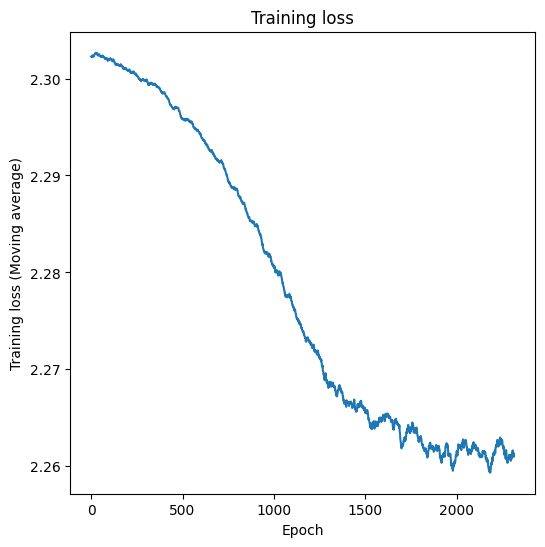

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
ys = [np.mean(losses[i : (i + 30)]) for i in range(len(losses) - 30)]
sns.lineplot(x=list(range(len(ys))), y=ys, ax=ax)
ax.set_title(f"Training loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Training loss (Moving average)")

In [13]:
blocks_indices = [0, 2, 4]

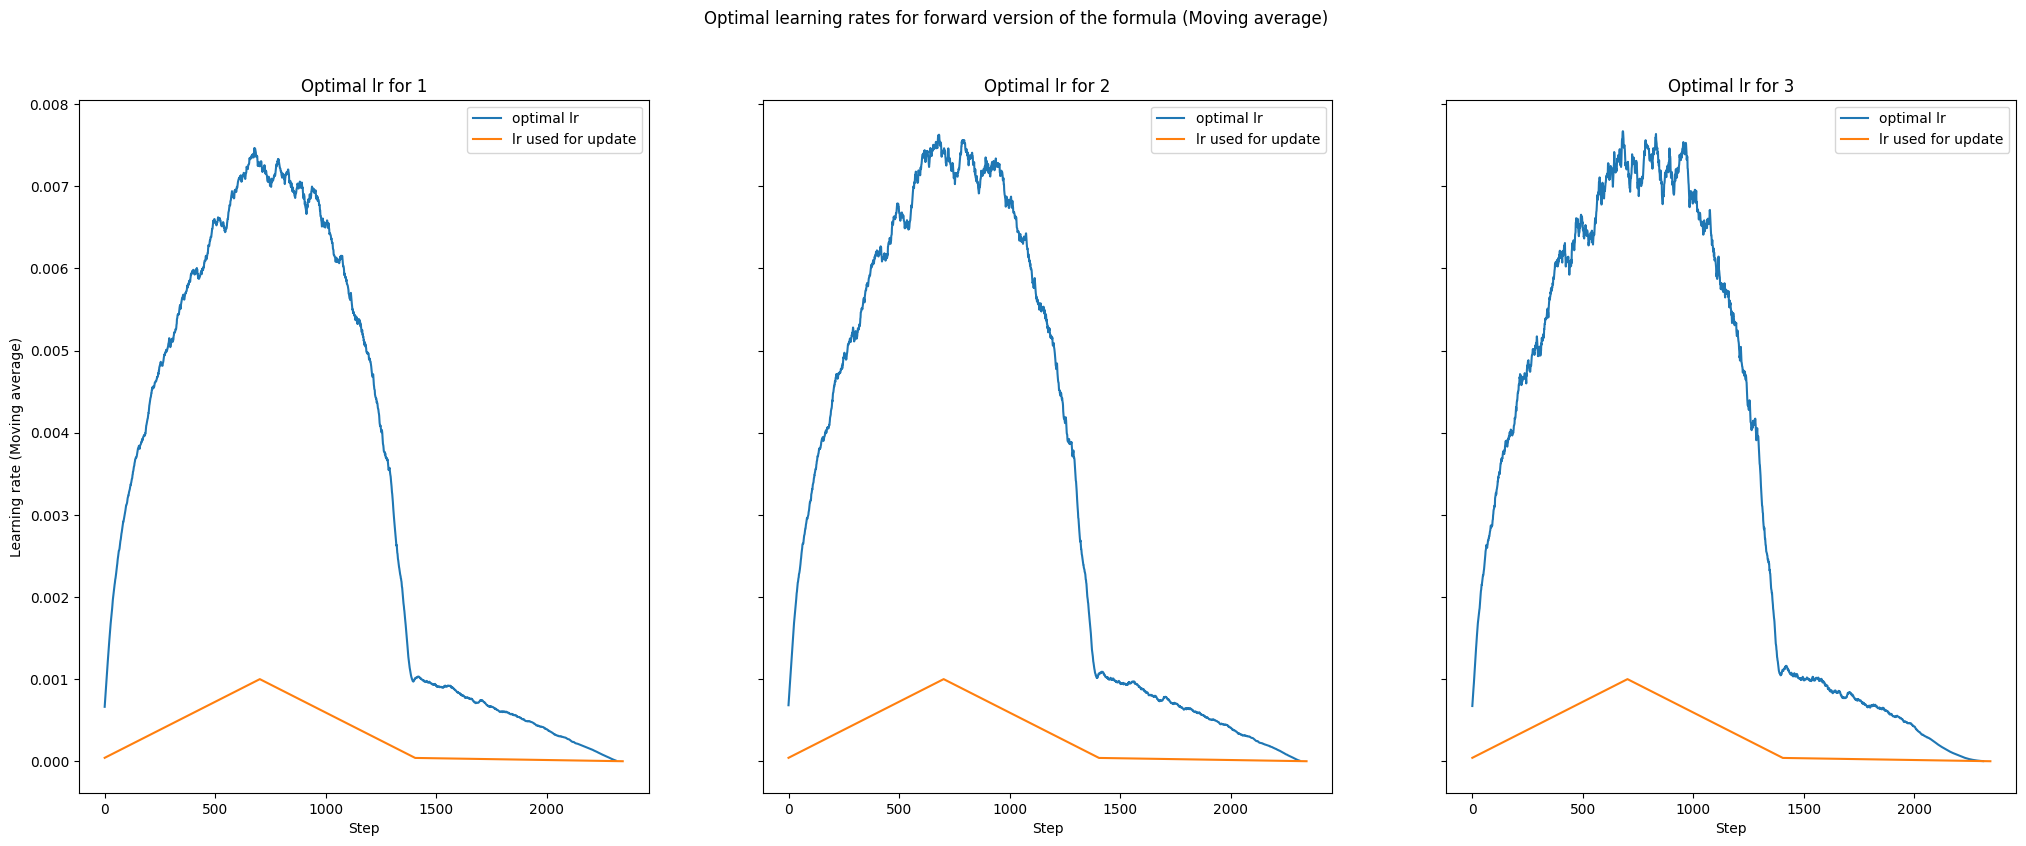

In [14]:
fig, ax = plt.subplots(ncols=len(blocks_indices), figsize=(25, 9), sharey=True)
fig.suptitle(
    "Optimal learning rates for forward version of the formula (Moving average)"
)
for idx in blocks_indices:
    plot_idx = idx // 2
    ys = [lr_forward[f"{idx}.weight"].item() for lr_forward in lrs_forward]
    ys = [np.mean(ys[i : (i + 30)]) for i in range(len(ys) - 30)]
    sns.lineplot(
        x=list(range(len(ys))), y=ys, ax=ax[plot_idx], label="optimal lr"
    )
    sns.lineplot(
        x=list(range(len(scheduler_lrs))),
        y=scheduler_lrs,
        ax=ax[plot_idx],
        label="lr used for update",
    )
    ax[plot_idx].set_title(f"Optimal lr for {plot_idx + 1}")
    ax[plot_idx].set_xlabel("Step")
    ax[plot_idx].set_ylabel("Learning rate (Moving average)")

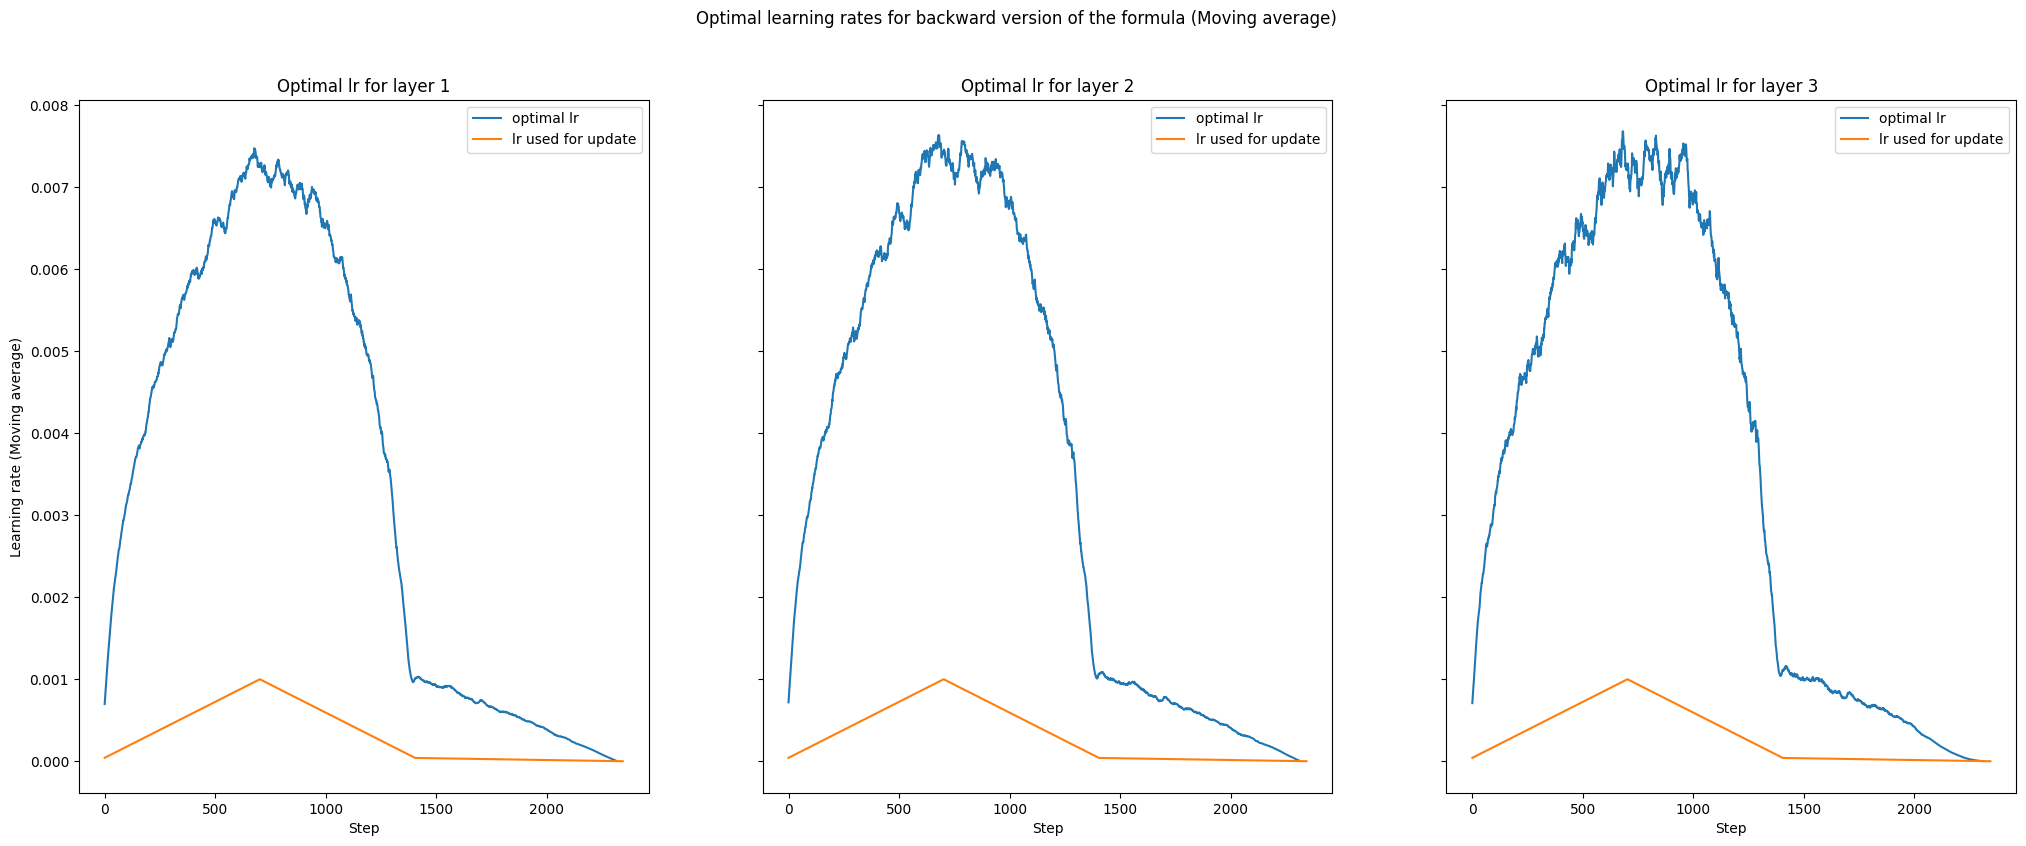

In [15]:
fig, ax = plt.subplots(ncols=len(blocks_indices), figsize=(25, 9), sharey=True)
fig.suptitle(
    "Optimal learning rates for backward version of the formula (Moving average)"
)
for idx in blocks_indices:
    plot_idx = idx // 2
    ys = [lr_backward[f"{idx}.weight"].item() for lr_backward in lrs_backward]
    ys = [np.mean(ys[i : (i + 30)]) for i in range(len(ys) - 30)]
    sns.lineplot(
        x=list(range(len(ys))), y=ys, ax=ax[plot_idx], label="optimal lr"
    )
    sns.lineplot(
        x=list(range(len(scheduler_lrs))),
        y=scheduler_lrs,
        ax=ax[plot_idx],
        label="lr used for update",
    )
    ax[plot_idx].set_title(f"Optimal lr for layer {plot_idx + 1}")
    ax[plot_idx].set_xlabel("Step")
    ax[plot_idx].set_ylabel("Learning rate (Moving average)")

In [6]:
from model import LeNet

model = LeNet()

In [13]:
X = next(iter(train_loader))[0]

In [14]:
X.shape

torch.Size([128, 1, 28, 28])

In [15]:
model(X)

torch.Size([128, 16, 4, 4])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x256 and 400x120)